# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

# Reading the dataset

In [2]:
df= pd.read_csv("dataset.csv")
df.head()

,brand_name,model,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,...,refresh_rate,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto,resolution_width,resolution_height
0,oneplus,OnePlus 11 5G,54999,89.0,True,True,False,snapdragon,8.0,3.2,...,120,3,1.0,android,50.0,16.0,0,NaN,1440,3216
1,oneplus,OnePlus Nord CE 2 Lite 5G,19989,81.0,True,False,False,snapdragon,8.0,2.2,...,120,3,1.0,android,64.0,16.0,1,1024.0,1080,2412
2,samsung,Samsung Galaxy A14 5G,16499,75.0,True,False,False,exynos,8.0,2.4,...,90,3,1.0,android,50.0,13.0,1,1024.0,1080,2408
3,motorola,Motorola Moto G62 5G,14999,81.0,True,False,False,snapdragon,8.0,2.2,...,120,3,1.0,android,50.0,16.0,1,1024.0,1080,2400
4,realme,Realme 10 Pro Plus,24999,82.0,True,False,False,dimensity,8.0,2.6,...,120,3,1.0,android,108.0,16.0,0,NaN,1080,2412


In [3]:
df.shape

(980, 26)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand_name                 980 non-null    object 
 1   model                      980 non-null    object 
 2   price                      980 non-null    int64  
 3   rating                     879 non-null    float64
 4   has_5g                     980 non-null    bool   
 5   has_nfc                    980 non-null    bool   
 6   has_ir_blaster             980 non-null    bool   
 7   processor_brand            960 non-null    object 
 8   num_cores                  974 non-null    float64
 9   processor_speed            938 non-null    float64
 10  battery_capacity           969 non-null    float64
 11  fast_charging_available    980 non-null    int64  
 12  fast_charging              769 non-null    float64
 13  ram_capacity               980 non-null    float64

# Data Preprocessing 

### Handling the missing values

In [5]:
# df.isnull().sum()*100/df.shape[0]

These columns have missing values:
* rating
* processor_brand
* num_cores
* processor_speed
* battery_capacity
* fast_charging
* num_front_cameras
* os
* primary_camera_front
* extended_upto

#### As because extended_auto column has approximately 49% missing values, we are dropping it.

In [6]:
df.drop("extended_upto", axis=1, inplace=True)

In [7]:
imputer_mean = SimpleImputer(strategy="mean")
imputer_median = SimpleImputer(strategy="median")
imputer_mode = SimpleImputer(strategy="most_frequent")

df["rating"] = imputer_mean.fit_transform(df["rating"].values.reshape(-1, 1))
df["processor_brand"] = imputer_mode.fit_transform(df["processor_brand"].values.reshape(-1, 1)).reshape(-1)
df["num_cores"] = imputer_median.fit_transform(df["num_cores"].values.reshape(-1, 1))
df["processor_speed"] = imputer_mean.fit_transform(df["processor_speed"].values.reshape(-1, 1))
df["battery_capacity"] = imputer_mean.fit_transform(df["battery_capacity"].values.reshape(-1, 1))
df["fast_charging"] = imputer_mean.fit_transform(df["fast_charging"].values.reshape(-1, 1))
df["num_front_cameras"] = imputer_median.fit_transform(df["num_front_cameras"].values.reshape(-1, 1))
df["os"] = imputer_mode.fit_transform(df["os"].values.reshape(-1, 1)).reshape(-1)
df["primary_camera_front"] = imputer_median.fit_transform(df["primary_camera_front"].values.reshape(-1, 1))

In [8]:
# df.isnull().sum()

In [9]:
df.drop("model", axis=1, inplace=True)

### Exploratory Data Analysis

In [10]:
df.drop(df[df["price"]==650000].index, axis=0, inplace=True)

In [11]:
df["brand_name"] = df["brand_name"].replace({"oneplus":"oppo",
                                             "realme":"xiaomi", 
                                             "redmi":"xiaomi",
                                             "poco":"xiaomi"})

In [12]:
df["fast_charging_available"] = df["fast_charging_available"].astype("bool")
df["extended_memory_available"] = df["extended_memory_available"].astype("bool")

In [13]:
num_col = df.select_dtypes(exclude=["object", "bool"]).columns
cat_col = df.select_dtypes(include=["object", "bool"]).columns

In [14]:
num_col

Index(['price', 'rating', 'num_cores', 'processor_speed', 'battery_capacity',
       'fast_charging', 'ram_capacity', 'internal_memory', 'screen_size',
       'refresh_rate', 'num_rear_cameras', 'num_front_cameras',
       'primary_camera_rear', 'primary_camera_front', 'resolution_width',
       'resolution_height'],
      dtype='object')

In [15]:
cat_col

Index(['brand_name', 'has_5g', 'has_nfc', 'has_ir_blaster', 'processor_brand',
       'fast_charging_available', 'os', 'extended_memory_available'],
      dtype='object')

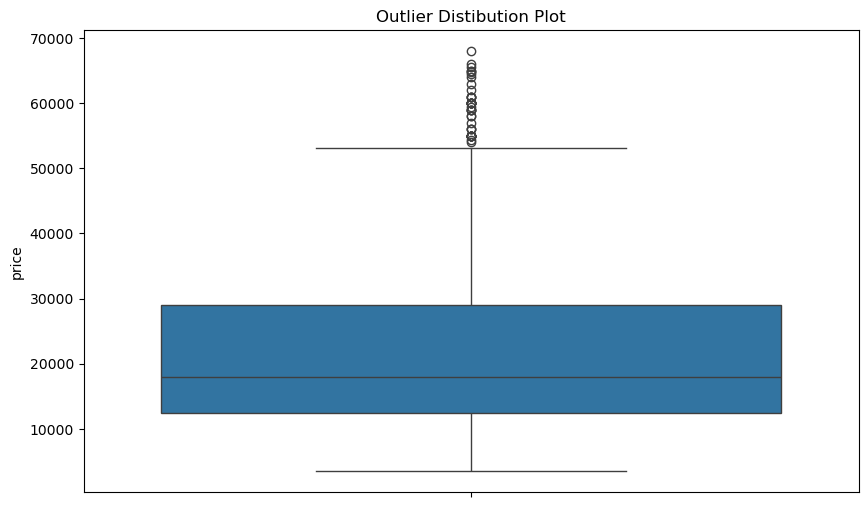

In [16]:
q1 = np.quantile(df["price"], 0.25)
q3 = np.quantile(df["price"], 0.75)
iqr = q3 - q1
limit = 1.5 * iqr
lower, upper = q1-limit, q3+limit

df_wth = df[(df["price"]>lower) & (df["price"]<upper)]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_wth["price"], orient="v")
plt.title("Outlier Distibution Plot")
plt.show()

In [17]:
# df["brand_name"].unique()

In [18]:
#Checking duplicates
df.drop_duplicates(inplace=True)

In [19]:
# plt.figure(figsize=(10, 6))
# ax = df["brand_name"].value_counts().plot(kind="bar", stacked=True)
# plt.title("Distribution according to brand name")
# plt.show()

It can be observed that Xiaomi and Samsung are mostly preferable smartphones followed by Vivo. 

In [20]:
# plt.figure(figsize=(10, 6))
# plt.title("Price Distribution Plot")
# sns.distplot(df["price"])

In [21]:
subset = df.iloc[np.arange(0, 974, 5)]

In [22]:
# plt.figure(figsize=(100, 50))
# sns.pairplot(subset[num_col])
# plt.title("Relationship between numerical columns")
# plt.show()

From the pairplots, we can observe that the following columns have higher correlation with the target column. 
P.S. I have to note that, pairplots have been designed according to undersampled dataset(subset)
* rating
* processor_speed
* fast_charging_available
* fast_charging
* ram_capacity
* internal_memory
* screen_size
* primary_camera_front
* resolution_height

In [23]:
subset[num_col].corr()["price"]

price                   1.000000
rating                  0.397198
num_cores              -0.118152
processor_speed         0.661848
battery_capacity       -0.085786
fast_charging           0.271713
ram_capacity            0.529061
internal_memory         0.708211
screen_size             0.255456
refresh_rate            0.327847
num_rear_cameras        0.264682
num_front_cameras       0.133904
primary_camera_rear     0.133649
primary_camera_front    0.217341
resolution_width        0.468286
resolution_height       0.530225
Name: price, dtype: float64

In [24]:
df[num_col].corr()["price"]

price                   1.000000
rating                  0.334652
num_cores              -0.057415
processor_speed         0.555791
battery_capacity       -0.135213
fast_charging           0.224014
ram_capacity            0.476091
internal_memory         0.656202
screen_size             0.231385
refresh_rate            0.301205
num_rear_cameras        0.186574
num_front_cameras       0.131972
primary_camera_rear     0.126608
primary_camera_front    0.207353
resolution_width        0.392030
resolution_height       0.418064
Name: price, dtype: float64

In [25]:
# correlation_matrix = df[num_col].corr()
# plt.figure(figsize=(15, 8))
# sns.heatmap(correlation_matrix, annot=True)
# plt.title("Correlation Plot")
# plt.show()

In [26]:
# for i in range (len(cat_col)):
#     for j in range (i+1, len(cat_col)):
#         cont_table = pd.crosstab(df[cat_col[i]], df[cat_col[j]])
#         chi2, p, dof, ex = chi2_contingency(cont_table)
#         print(f"Chi-square test between {cat_col[i]} and {cat_col[j]}: p-value = {p}")

In [27]:
# for col in cat_col:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=subset[col], y=subset["price"], orient = "v", data=subset)
#     plt.xticks(rotation=90)
#     plt.title(f"Correlation between {col} and Price column")
#     plt.show()

From boxplots, we can observe that the following columns hava important relation with the price columns:
* brand_name
* has_5g
* has_nfc
* processor_brand
* os
* extended_memory_available

### Column Generation 

In [28]:
df_copy = df.copy()
temp = df_copy.groupby(["brand_name"])["price"].mean()
df_copy = df_copy.merge(temp.reset_index(), how="left", on="brand_name")

In [29]:
dct = {}
for i in range (df_copy["price_y"].nunique()): 
    if df_copy["brand_name"].unique()[i] not in dct:
        dct[df_copy["brand_name"].unique()[i]] = df_copy["price_y"].unique()[i]

In [30]:
bins = [0, 25000, 50000, 130000]
label = ["budget_friendly", "middle_range", "expensive"]
df["category"] = pd.cut(df_copy["price_y"], bins, right=False, labels=label)

In [31]:
df.head()

,brand_name,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,battery_capacity,...,refresh_rate,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_width,resolution_height,category
0,oppo,54999,89.0,True,True,False,snapdragon,8.0,3.2,5000.0,...,120,3,1.0,android,50.0,16.0,False,1440,3216,middle_range
1,oppo,19989,81.0,True,False,False,snapdragon,8.0,2.2,5000.0,...,120,3,1.0,android,64.0,16.0,True,1080,2412,middle_range
2,samsung,16499,75.0,True,False,False,exynos,8.0,2.4,5000.0,...,90,3,1.0,android,50.0,13.0,True,1080,2408,middle_range
3,motorola,14999,81.0,True,False,False,snapdragon,8.0,2.2,5000.0,...,120,3,1.0,android,50.0,16.0,True,1080,2400,budget_friendly
4,xiaomi,24999,82.0,True,False,False,dimensity,8.0,2.6,5000.0,...,120,3,1.0,android,108.0,16.0,False,1080,2412,budget_friendly


### Seperating Necessary columns

In [32]:
necessary_col = ["price", "rating", "processor_speed", "fast_charging", "ram_capacity",
                 "internal_memory", "screen_size", "primary_camera_front", "resolution_height",
                
                "brand_name", "has_5g", "has_nfc", "fast_charging_available", "processor_brand", "os",
                 "extended_memory_available", "category"]

In [33]:
data = df[necessary_col]

In [34]:
necessary_num_col = ["price", "rating", "processor_speed", "fast_charging", "ram_capacity",
                 "internal_memory", "screen_size", "primary_camera_front", "resolution_height"]

In [35]:
necessary_cat_col = ["brand_name", "has_5g", "has_nfc", "fast_charging_available", "processor_brand", "os",
                 "extended_memory_available", "category"]

### Encoding 

In [36]:
dummies = pd.get_dummies(data[necessary_cat_col], drop_first=True, dtype="int64")

In [37]:
dummies.shape

(975, 60)

In [38]:
data = pd.concat([data, dummies], axis=1)
data.shape

(975, 77)

In [39]:
data.drop(necessary_cat_col, axis=1, inplace=True)
data.shape

(975, 65)

### Splitting training and test datasets

In [40]:
np.random.seed(0)
data_train, data_test = train_test_split(data, train_size= 0.75, random_state=42)

### Scaling 

In [41]:
ss = StandardScaler()
data_train[necessary_num_col] = ss.fit_transform(data_train[necessary_num_col])

In [42]:
y_train = data_train["price"]
X_train = data_train.drop("price", axis=1)

# Model Creation 

In [43]:
test = data.iloc[-5:]
data = data.iloc[:-5]

In [44]:
y = data["price"]
X = data.drop("price", axis=1)

In [45]:
necessary_num_col.remove("price")

In [46]:
X[necessary_num_col] = ss.fit_transform(X[necessary_num_col])

In [47]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Train-test split on polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a linear regression model on polynomial features
model = RandomForestRegressor()
model.fit(X_train_poly, y_train)
y_pred_poly = model.predict(X_test_poly)

# Calculate R-squared for polynomial features
# r2_poly = model.score(X_test_poly, y_test)
r2_orig = r2_score(y_test, y_pred_poly)
print(f'R-squared with Polynomial Features: {r2_orig}')


R-squared with Polynomial Features: 0.8673515801858902


In [71]:
data_rfe = data[col_sup]
data_poly = poly.fit_transform(data_rfe)

X_train_rfe_poly, X_test_rfe_poly, y_train, y_test = train_test_split(data_poly, y, train_size=0.75, random_state=42)

rfc = RandomForestRegressor()
rfc.fit(X_train_rfe_poly, y_train)
y_rfe_pred = rfc.predict(X_test_rfe_poly)

r2_rfe = r2_score(y_test, y_rfe_pred)
print(f"Accuracy is {r2_rfe}")


NameError: name 'col_sup' is not defined

In [49]:
poly_point = X_test_poly[1]
model.predict(poly_point.reshape(1, -1))

array([17026.105])

In [50]:
y_test

577    13990
260    15499
389    70990
497    11999
70      9499
       ...  
969    32990
748    11499
897     9022
33     38999
31     20999
Name: price, Length: 194, dtype: int64

In [51]:
poly_point.reshape(1, -1)

array([[-0.04175398, -0.06164538, -0.92308502, ...,  0.        ,
         0.        ,  0.        ]])

In [52]:
test_y = test["price"]
test_X = test.drop("price", axis=1)

In [53]:
test_X_poly = poly.transform(test_X)

In [54]:
preds = []
for i in test_X_poly:
    datapoint = i.reshape(1, -1)
    prediction = model.predict(datapoint)
    preds.append(prediction)

In [55]:
preds

[array([110591.03]),
 array([110260.94]),
 array([108668.13]),
 array([110591.03]),
 array([111200.63])]

In [56]:
r2_score(test_y, preds)

-151.74705775705647

In [57]:
# X_train_1 = X_train["processor_speed"]

In [58]:
# X_train_1c = sm.add_constant(X_train_1)

# lr_1 = sm.OLS(y_train, X_train_1c).fit()

In [59]:
# lr_1.params

In [60]:
# lr_1.params[0]

In [61]:
# plt.scatter(X_train_1c.iloc[:, 1], y_train)
# plt.plot(X_train_1c.iloc[:, 1], lr_1.params[1]*X_train.iloc[:, 1]+lr_1.params[0], "r")
# plt.show()

In [62]:
# print(lr_1.summary())

In [63]:
# X_train_2 = X_train[["rating", "processor_speed"]]

In [64]:
# X_train_2c = sm.add_constant(X_train_2)

# lr_2 = sm.OLS(y_train, X_train_2c).fit()

In [65]:
# print(lr_2.summary())

In [66]:
# X_train_3 = X_train[["rating", "processor_speed", "internal_memory"]]

In [67]:
# X_train_3c = sm.add_constant(X_train_3)

# lr_3 = sm.OLS(y_train, X_train_3c).fit()

In [68]:
# print(lr_3.summary())

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

In [70]:
lm = GradientBoostingRegressor()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=30)
rfe = rfe.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [731, 776]

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
col_sup = X_train.columns[rfe.support_]

In [ ]:
col_sup

In [ ]:
X_train_rfe = X_train[col_sup]

Conditions for either dropping or accepting the column
* High p-value and high VIF => drop the column
* High p-value Low VIF or Low p-value, High VIF => drop the column with High p-value first
* Low p-value Low VIF => accept the column

In [ ]:
# X_train_rfec = sm.add_constant(X_train_rfe)

# lm_rfe = sm.OLS(y_train, X_train_rfec).fit()
# print(lm_rfe.summary())

In [ ]:
# vif = pd.DataFrame()
# vif["features"] = X_train_rfe.columns
# vif["vif"] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
# vif["vif"] = round(vif["vif"], 2)
# vif = vif.sort_values(by="vif", ascending=False)
# vif

In [ ]:
# def rfe_lm(X_train, y_train=y_train):

#     X_train_c = sm.add_constant(X_train)
#     lm = sm.OLS(y_train, X_train_c).fit()
    
#     print(lm.summary())

In [ ]:
# def vif_gen(X_train):

#     vif = pd.DataFrame()
#     vif["features"] = X_train.columns
#     vif["vif"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
#     vif["vif"] = round(vif["vif"], 2)
#     vif = vif.sort_values(by="vif", ascending=False)
    
#     return vif

In [ ]:
# X_train_rfe1 = X_train_rfe.drop(["os_other", "fast_charging", "category_middle_range",
#                                 "brand_name_asus", "brand_name_google", "primary_camera_front", "brand_name_nubia",
#                                 "processor_brand_exynos", "brand_name_nokia", "brand_name_xiaomi",
#                                  "brand_name_lg", "brand_name_vivo", "processor_brand_snapdragon",
#                                 "processor_brand_google", "brand_name_motorola", "brand_name_oppo", "brand_name_honor"], axis=1)

In [ ]:
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.model_selection import cross_val_score

# # Ridge Regression
# ridge_model = Ridge(alpha=1.0)
# ridge_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')
# print(f'Ridge Regression R-squared: {np.mean(ridge_scores)}')

# # Lasso Regression
# lasso_model = Lasso(alpha=0.1)
# lasso_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='r2')
# print(f'Lasso Regression R-squared: {np.mean(lasso_scores)}')


In [ ]:
# r2_score(y_test, y_pred_poly)